In [ ]:
! pip install pytorch-lightning -q
! pip list | grep torch
! nvidia-smi

In [ ]:
import random
import torch
def seed_everything(seed=7):
    random.seed(seed)
    os.environ['PYTHONHASHSEED']= str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False

In [ ]:
%matplotlib inline
import numpy as np
import os
import json
import pandas as pd
from pprint import pprint

base_path = '../input/plant-pathology-2021-fgvc8-960px/'
IMG_PATH='../input/plant-pathology-2021-fgvc8-960px/train_images'
path_csv = os.path.join(base_path, 'train.csv')
train_data = pd.read_csv(path_csv)
#test_data=pd.read_csv(os.path.join(base_path, 'test_csv.csv'))

In [ ]:
import itertools
import seaborn as sns

labels_all = list(train_data['labels'])
ax = sns.countplot(y=sorted(labels_all), orient='v')
ax.grid()

In [ ]:
# comp= ['frog_eye_leaf_spot complex','complex','powdery_mildew complex','rust complex','rust frog_eye_leaf_spot','scab frog_eye_leaf_spot','scab frog_eye_leaf_spot complex']
# result=filter(lambda x : train_data.iloc[x,:]['labels'] in comp,train_data.index)
# train_data=train_data.drop(result)

In [ ]:
data = pd.read_csv('../input/traindata/data (5).csv')
data.head()

In [ ]:
print(data['labels'].value_counts())

**< imbalance data를 해결하는 방법 >**

1. oversampling 
장점 : under-sampling보다 성능이 뛰어나다. 
단점 : minor class를 판별시 과적합 될 가능성이 있다.

2. undersampling
장점 :  모델이 빨리 돌아간다.
단점 : 과적합

3. SMOTE : 주변에 있는 데이터셋의 특징과 유사하게 데이터를 생성한다.
장점 : 데이터 손실을 하지 않으면서 과적합을 피할 수 있다.
단점 : 고차원 데이터에 효율적이지 않다.

우리는 고차원 데이터를 다루고 있기때문에 oversampling을 쓸 것이다.

**< Pytorch 에서는 어떻게 ? >** 

파이토치에서 sampler 옵션을 사용하면 데이터 크래스와 상호 작용하고 이 클래스에서 샘플링 하는 방법을 알려준다.
다른 클래스의 가중치를 사용하여 sampler 클래스 객체를 생성하는 방식이다.

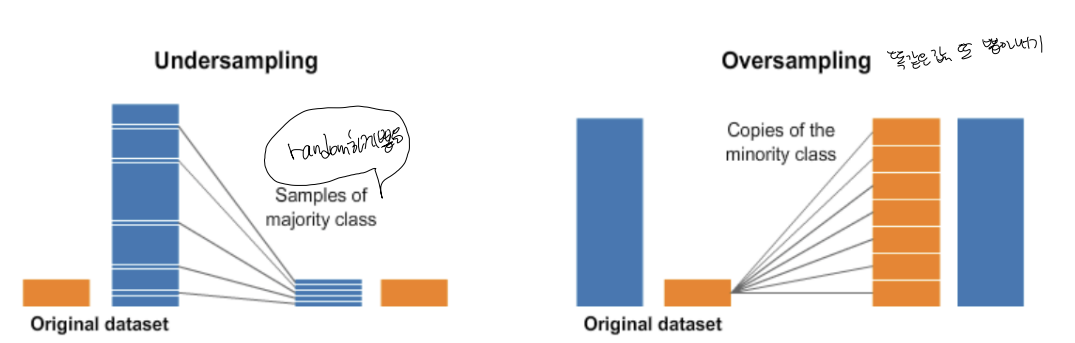

**< 주의할 점! >**

반드시 cross-validation을 한 후에 데이터를 증강시킨다.
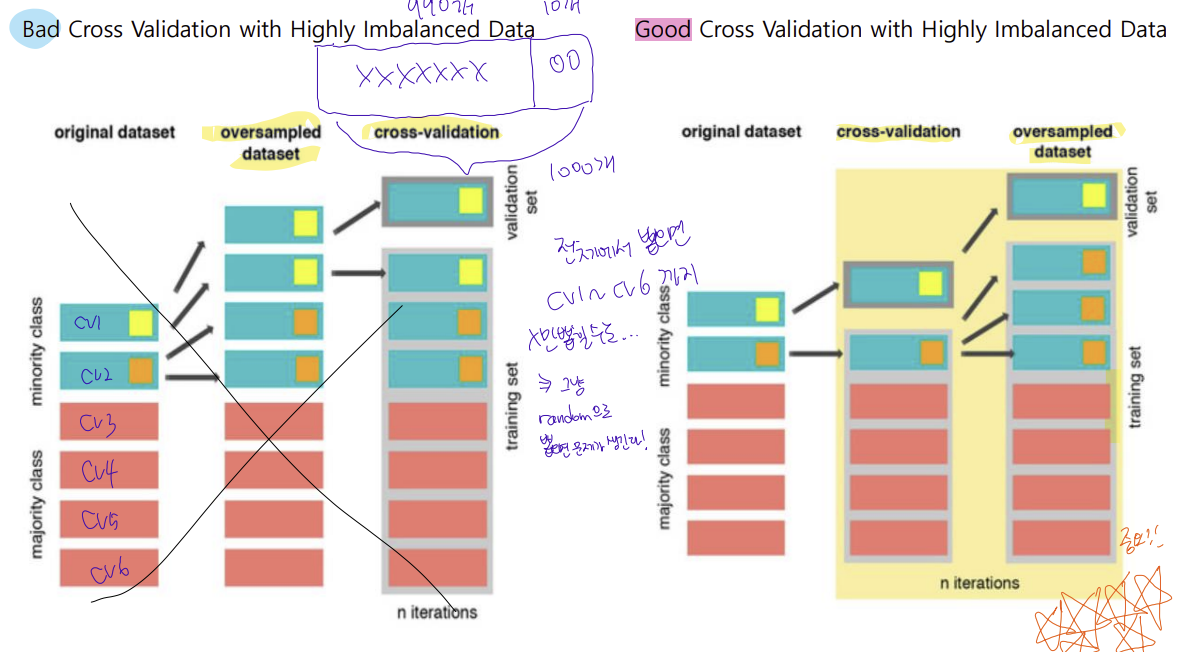

#EDA

In [ ]:
import cv2
def load_image(image_id):
    file_path = image_id 
    image = cv2.imread(IMG_PATH +'/' +file_path)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

train_images = data["image"][:100].apply(load_image)

In [ ]:
# labels_unique = set(labels_all)
# print(f"unique labels: {labels_unique}")
# train_data['labels_sorted'] = [" ".join(sorted(lbs.split(" "))) for lbs in train_data['labels']]

# labels_combine = {}
# for comb in train_data['labels_sorted']:
#     labels_combine[comb] = labels_combine.get(comb, 0) + 1

# show_counts = '\n'.join(sorted(f'\t{k}: {v}' for k, v in labels_combine.items()))
# print(f"unique combinations: \n" + show_counts)
# print(f"total: {sum(labels_combine.values())}")

In [ ]:
import matplotlib.pyplot as plt

nb_samples = 5
n, m = len(np.unique(data['labels'])), nb_samples,
fig, axarr = plt.subplots(nrows=n, ncols=m, figsize=(m * 2, n * 2))
for ilb, (lb, df_) in enumerate(data.groupby('labels')):
    img_names = list(df_['image'])
    for i in range(m):
        img_name = img_names[i]
        img = plt.imread(os.path.join(base_path, f"train_images/{img_name}"))
        axarr[ilb, i].imshow(img)
        if i == 0:
            axarr[ilb, i].set_title(f"{lb} #{len(df_)}")
        axarr[ilb, i].set_xticks([])
        axarr[ilb, i].set_yticks([])
plt.axis('off')

In [ ]:
import plotly.figure_factory as ff
red_values = [np.mean(train_images[idx][:, :, 0]) for idx in range(len(train_images))]
green_values = [np.mean(train_images[idx][:, :, 1]) for idx in range(len(train_images))]
blue_values = [np.mean(train_images[idx][:, :, 2]) for idx in range(len(train_images))]
values = [np.mean(train_images[idx]) for idx in range(len(train_images))]

In [ ]:
fig = ff.create_distplot([values], group_labels=["Channels"], colors=["purple"])
fig.update_layout(showlegend=False, template="simple_white")
fig.update_layout(title_text="Distribution of channel values")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig
#정상적인 분포가 아니다!

In [ ]:
fig = ff.create_distplot([red_values], group_labels=["R"], colors=["red"])
fig.update_layout(showlegend=False, template="simple_white")
fig.update_layout(title_text="Distribution of red channel values")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig

In [ ]:
fig = ff.create_distplot([green_values], group_labels=["G"], colors=["green"])
fig.update_layout(showlegend=False, template="simple_white")
fig.update_layout(title_text="Distribution of green channel values")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig

In [ ]:
fig = ff.create_distplot([blue_values], group_labels=["B"], colors=["blue"])
fig.update_layout(showlegend=False, template="simple_white")
fig.update_layout(title_text="Distribution of blue channel values")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()

for idx, values in enumerate([red_values, green_values, blue_values]):
    if idx == 0:
        color = "Red"
    if idx == 1:
        color = "Green"
    if idx == 2:
        color = "Blue"
    fig.add_trace(go.Box(x=[color]*len(values), y=values, name=color, marker=dict(color=color.lower())))
    
fig.update_layout(yaxis_title="Mean value", xaxis_title="Color channel",
                  title="Mean value vs. Color channel", template="plotly_white")

In [ ]:
fig = ff.create_distplot([red_values, green_values, blue_values],
                         group_labels=["R", "G", "B"],
                         colors=["red", "green", "blue"])
fig.update_layout(title_text="Distribution of red channel values", template="simple_white")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig.data[1].marker.line.color = 'rgb(0, 0, 0)'
fig.data[1].marker.line.width = 0.5
fig.data[2].marker.line.color = 'rgb(0, 0, 0)'
fig.data[2].marker.line.width = 0.5
fig

In [ ]:
def edge_and_cut(img):
    emb_img = img.copy()
    edges = cv2.Canny(img, 100, 200)
    edge_coors = []
    for i in range(edges.shape[0]):
        for j in range(edges.shape[1]):
            if edges[i][j] != 0:
                edge_coors.append((i, j))
    
    row_min = edge_coors[np.argsort([coor[0] for coor in edge_coors])[0]][0]
    row_max = edge_coors[np.argsort([coor[0] for coor in edge_coors])[-1]][0]
    col_min = edge_coors[np.argsort([coor[1] for coor in edge_coors])[0]][1]
    col_max = edge_coors[np.argsort([coor[1] for coor in edge_coors])[-1]][1]
    new_img = img[row_min:row_max, col_min:col_max]
    
    emb_img[row_min-10:row_min+10, col_min:col_max] = [255, 0, 0]
    emb_img[row_max-10:row_max+10, col_min:col_max] = [255, 0, 0]
    emb_img[row_min:row_max, col_min-10:col_min+10] = [255, 0, 0]
    emb_img[row_min:row_max, col_max-10:col_max+10] = [255, 0, 0]
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 20))
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Original Image', fontsize=24)
    ax[1].imshow(new_img, cmap='gray')
    ax[1].set_title('Canny Edges', fontsize=24)
    ax[2].imshow(emb_img, cmap='gray')
    ax[2].set_title('Bounding Box', fontsize=24)
    plt.show()

데이터셋 준비!

In [ ]:
from sklearn.model_selection import StratifiedKFold
n_iter=0
skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(data['image'], data['labels']):
            n_iter+=1
import os
import torch
from PIL import Image
from torch.utils.data import Dataset

class PlantPathologyDataset(Dataset):
    def __init__(
        self,
        path_csv: str= '../input/traindata/data (5).csv',
        path_img_dir: str = os.path.join(base_path, 'train_images'),
        transforms = None,
        mode: str = 'train',
        split: float = 0.8,
    ):
        self.path_img_dir = path_img_dir
        self.transforms = transforms
        self.mode = mode

        self.data = pd.read_csv(path_csv)
        labels_all = list(itertools.chain(*[lbs.split(" ") for lbs in self.data['labels']]))
        self.labels_unique = sorted(set(labels_all))
        self.labels_lut = {lb: i for i, lb in enumerate(self.labels_unique)}
        self.num_classes = len(self.labels_unique)

        # split dataset
        self.data = self.data.sample(frac=1).reset_index(drop=True)
        self.data = self.data.iloc[train_index] if mode == 'train' else self.data.iloc[test_index]
        self.img_names = list(self.data['image'])
        self.labels = list(self.data['labels'])

    def to_one_hot(self, labels: str) -> tuple:
        one_hot = [0] * len(self.labels_unique)
        for lb in labels.split(" "):
            one_hot[self.labels_lut[lb]] = 1
        return tuple(one_hot)

    def __getitem__(self, idx: int) -> tuple:
        img_path = os.path.join(self.path_img_dir, self.img_names[idx])
        assert os.path.isfile(img_path)
        label = self.labels[idx]
        img = plt.imread(img_path)

        # augmentation
        if self.transforms:
            img = self.transforms(Image.fromarray(img))
        label = self.to_one_hot(label)
        label=np.argmax(label).reshape(-1,1)
        return img, torch.tensor(label[0][0])

    def __len__(self) -> int:
        return len(self.data)

# ==============================
# ==============================

dataset = PlantPathologyDataset()

# quick view
fig = plt.figure(figsize=(9, 6))
for i in range(9):
    img, lb = dataset[i]
    print(img.shape)
    print(lb.shape)
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    ax.imshow(img)
    ax.set_title(lb)

In [ ]:
train_data = data.iloc[train_index,]
test_data=data.iloc[test_index,]

In [ ]:
from torchvision import transforms as T
TRAIN_TRANSFORM = T.Compose([
    T.Resize(512),
    T.RandomPerspective(),
    T.RandomResizedCrop(224),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.RandomRotation(degrees=(0, 180)),
    T.ColorJitter(brightness=.1, hue=.1),
    T.ToTensor(),
    T.Normalize([0.385, 0.356, 0.306], [0.229, 0.224, 0.225]),
    # T.Normalize([0.431, 0.498,  0.313], [0.237, 0.239, 0.227]),  # custom
])

VALID_TRANSFORM = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize([0.385, 0.356, 0.306], [0.229, 0.224, 0.225]),
    # T.Normalize([0.431, 0.498,  0.313], [0.237, 0.239, 0.227]),  # custom
])

In [ ]:
import multiprocessing as mproc
import pytorch_lightning as pl
from torch.utils.data import DataLoader

class PlantPathologyDM(pl.LightningDataModule):
    dataset_cls = PlantPathologyDataset

    def __init__(
        self,
        path_csv: str = '../input/traindata/data (5).csv',
        path_img_dir: str = os.path.join(base_path, 'train_images'),
        batch_size: int = 128,
        num_workers: int = None,
    ):
        super().__init__()
        self.path_csv = path_csv
        self.path_img_dir = path_img_dir
        self.batch_size = batch_size
        self.num_workers = num_workers if num_workers is not None else mproc.cpu_count()
        self.train_dataset = None
        self.test_dataset = None

    def prepare_data(self):
        pass

    @property
    def num_classes(self) -> int:
        assert self.train_dataset and self.test_dataset
        return max(self.train_dataset.num_classes, self.test_dataset.num_classes)

    def setup(self, stage=None):
        self.train_dataset = self.dataset_cls(self.path_csv, self.path_img_dir, mode='train', transforms=TRAIN_TRANSFORM)
        print(f"training dataset: {len(self.train_dataset)}")
        self.test_dataset = self.dataset_cls(self.path_csv, self.path_img_dir, mode='test', transforms=VALID_TRANSFORM)
        print(f"test dataset: {len(self.test_dataset)}")

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
        )


    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
        )

# ==============================
# ==============================

dm = PlantPathologyDM()
dm.setup()
print(dm.num_classes)

# quick view
fig = plt.figure(figsize=(3, 7))
for imgs, lbs in dm.train_dataloader():
    print(f'batch labels: {torch.sum(lbs, axis=0)}')
    print(f'image size: {imgs[0].shape}')
    print(type(imgs))
    for i in range(3):
        ax = fig.add_subplot(3, 1, i + 1, xticks=[], yticks=[])
        # print(np.rollaxis(imgs[i].numpy(), 0, 3).shape)
        ax.imshow(np.rollaxis(imgs[i].numpy(), 0, 3))
        ax.set_title(lbs[i])
    break

In [ ]:
norm_train=[]
for j in range(0,100):
    norm_train.append(dm.train_dataset[j][0].numpy())
len(norm_train)

In [ ]:
red_values = [np.mean(norm_train[idx][:, :, 0]) for idx in range(len(norm_train))]
green_values = [np.mean(norm_train[idx][:, :, 1]) for idx in range(len(norm_train))]
blue_values = [np.mean(norm_train[idx][:, :, 2]) for idx in range(len(norm_train))]
values = [np.mean(norm_train[idx]) for idx in range(len(norm_train))]


In [ ]:

fig = ff.create_distplot([values], group_labels=["Channels"], colors=["purple"])
fig.update_layout(showlegend=False, template="simple_white")
fig.update_layout(title_text="Distribution of channel values")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig

In [ ]:
fig = ff.create_distplot([red_values], group_labels=["R"], colors=["red"])
fig.update_layout(showlegend=False, template="simple_white")
fig.update_layout(title_text="Distribution of red channel values")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig

In [ ]:
fig = ff.create_distplot([green_values], group_labels=["G"], colors=["green"])
fig.update_layout(showlegend=False, template="simple_white")
fig.update_layout(title_text="Distribution of green channel values")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig

In [ ]:
fig = ff.create_distplot([blue_values], group_labels=["B"], colors=["blue"])
fig.update_layout(showlegend=False, template="simple_white")
fig.update_layout(title_text="Distribution of blue channel values")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig

In [ ]:
fig = ff.create_distplot([red_values, green_values, blue_values],
                         group_labels=["R", "G", "B"],
                         colors=["red", "green", "blue"])
fig.update_layout(title_text="Distribution of red channel values", template="simple_white")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig.data[1].marker.line.color = 'rgb(0, 0, 0)'
fig.data[1].marker.line.width = 0.5
fig.data[2].marker.line.color = 'rgb(0, 0, 0)'
fig.data[2].marker.line.width = 0.5
fig

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

##CNN Model

In [ ]:
def create_model(pretrained=True):
    model = torchvision.models.resnet50(pretrained=True)
    
    for param in model.layer1.parameters():
        param.requires_grad = False
        
    for param in model.layer2.parameters():
        param.requires_grad = False  
        
    for param in model.layer3.parameters():
        param.requires_grad = False 
    
    model.fc = torch.nn.Sequential(
        torch.nn.Linear(
            in_features=model.fc.in_features,
            out_features=5
        ),
        torch.nn.Sigmoid()
    ).to(device)
    
    return model


In [ ]:
!pip install efficientnet_pytorch 

In [ ]:
def create_model2(pretrained=True):
    model = torchvision.models.efficientnet_b5(pretrained=True)

    for param in model.parameters():
        param.requires_grad = False

    
    model.classifier = torch.nn.Sequential(
        torch.nn.Linear(
            in_features=model.classifier[1].in_features,
            out_features=5
        ),
        nn.Dropout(p=0.5),
        torch.nn.Sigmoid()
    ).to(device)
    
    return model

In [ ]:

num_epochs=10
def train_epoch(model,device,dataloader,optimizer,loss_fn):
    train_loss,train_correct=0.0,0
    model.train()
    for images, labels in dataloader:

        images,labels = images.to(device),labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output,labels )
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()
    return train_loss,train_correct
  
def valid_epoch(model,device,dataloader,loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    for images, labels in dataloader:

        images,labels = images.to(device),labels.to(device)
        output = model(images)
        loss=loss_fn(output,labels)
        valid_loss+=loss.item()*images.size(0)
        scores, predictions = torch.max(output.data,1)
        val_correct+=(predictions == labels).sum().item()

    return valid_loss,val_correct

In [ ]:
import wandb

In [ ]:
import torch.nn as nn
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        BCE_loss = nn.CrossEntropyLoss()(inputs, targets)

        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
              return torch.mean(F_loss)
        else:
              return F_loss

In [ ]:
pip install 'git+https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup'

In [ ]:
from cosine_annealing_warmup import CosineAnnealingWarmupRestarts
import torchvision
import tensorflow as tf
foldperf={}
from torch.utils.data import SubsetRandomSampler
nSamples = [1860,3181,4624,1184,4826]
normedWeights = [1 - (x / sum(nSamples)) for x in nSamples]
normedWeights = torch.FloatTensor(normedWeights).to(device)
criterion = nn.CrossEntropyLoss(normedWeights)
model = create_model(pretrained=True).to(device)
wandb.init(project='early stopping',entity='dahyeon')
wandb.watch(model,criterion,log="all",log_freq=10)
# early_stopping
last_loss = 100
patience = 2
trigger_times = 0
iters=len(dm.train_dataset)
temp=0
for fold, (train_idx,val_idx) in enumerate(skf.split(train_data['image'], train_data['labels'])):

    print('Fold {}'.format(fold + 1))
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(PlantPathologyDataset(mode='train', transforms=TRAIN_TRANSFORM), batch_size=8,sampler=train_sampler)
    test_loader = DataLoader(PlantPathologyDataset(mode='train', transforms=VALID_TRANSFORM), batch_size=8,sampler=test_sampler)
    
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
    scheduler = CosineAnnealingWarmupRestarts(optimizer,
                                          first_cycle_steps=200,
                                          cycle_mult=1.0,
                                          max_lr=0.001,
                                          min_lr=0.000001,
                                          warmup_steps=50,
                                          gamma=1.0)
    history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}
    for epoch in range(num_epochs):
        temp+=5
        train_loss, train_correct=train_epoch(model,device,train_loader,optimizer,criterion)
        test_loss, test_correct=valid_epoch(model,device,test_loader,criterion)
        train_loss = train_loss / len(train_loader.sampler)
        train_acc = train_correct / len(train_loader.sampler) * 100
        test_loss = test_loss / len(test_loader.sampler)
        test_acc = test_correct / len(test_loader.sampler) * 100
        scheduler.step()
        if train_loss > last_loss:
            trigger_times += 1
            print('Trigger Times:', trigger_times)

            if trigger_times >= patience:
                print('Early stopping!\nStart to test process.')
                model = create_model(pretrained=True).to(device)
                model.load_state_dict(torch.load('best_model.pt'))

        else:
            print('trigger times: 0')
            trigger_times =0
            torch.save(model.state_dict(), 'best_model.pt')
            last_loss =train_loss
        print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(epoch + 1,
                                                                                                             num_epochs,
                                                                                                             train_loss,
                                                                                                             test_loss,
                                                                                                             train_acc,
                                                                                                             test_acc))
        wandb.log({'Epoch':epoch, 'train':{"acc":train_acc,"loss":train_loss},'val':{"acc":test_acc,"loss":test_loss}})
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)
        
    foldperf['fold{}'.format(fold+1)] = history  

torch.save(model,'k_cross_CNN_version2.pt')   

In [ ]:
for fold, (train_idx,val_idx) in enumerate(skf.split(train_data['image'], train_data['labels'])):
    globals()['train_fold{}'.format(fold)] = train_idx
print(len(set(train_fold2) & set(train_fold3)))

In [ ]:
labels_all=list(itertools.chain(*[lbs.split(" ") for lbs in data['labels']]))
labels_unique = sorted(set(labels_all))
labels_lut = {lb: i for i, lb in enumerate(labels_unique)}
num_classes = len(labels_unique)
categories=[k for k,v in labels_lut.items()]
labels_lut

In [ ]:
labels_lut.items()

In [ ]:
import torchvision
model2 = create_model2(pretrained=True).to(device)
model2.load_state_dict(torch.load('best_model.pt'))
torch.save(model2,'eff_model.pt')   
model2.eval()

In [ ]:
preds = []
dm.batch_size = 256
total_batch = int(3979/dm.batch_size)
for i in range(total_batch):
    for imgs, names in dm.test_dataloader():
            with torch.no_grad():
                imgs=imgs.cuda()
                encode = model2(imgs)
                #print(encode)
            #print(np.round(encode.cpu().numpy(), decimals=2))
            for be, name in zip(encode,names ):#여기서 be는 encode 원소들 즉, 예측결과
#                 count= count_frequency(np.round(be.cpu().numpy(), decimals=2))
#                 if 1.0 in count.keys() and count[1.0]==2 :
#                         temp=np.argpartition(be.cpu().detach().numpy(), -2)[-2:]
#                         lbs=int(name.numpy()) if name.numpy() in temp else temp[0]
                lbs=np.argmax(be.cpu().detach().numpy())
                preds.append(dict(labels=int(name.numpy()), predict=lbs))
            break

df_preds = pd.DataFrame(preds)
print(df_preds.head())

In [ ]:
data = {'y_Actual':    list(df_preds['labels'].values),
        'y_Predicted': list(df_preds['predict'].values),
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
print (df)

In [ ]:
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(df['y_Predicted'],df['y_Actual']))